### Imports

In [1]:
import cv2
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

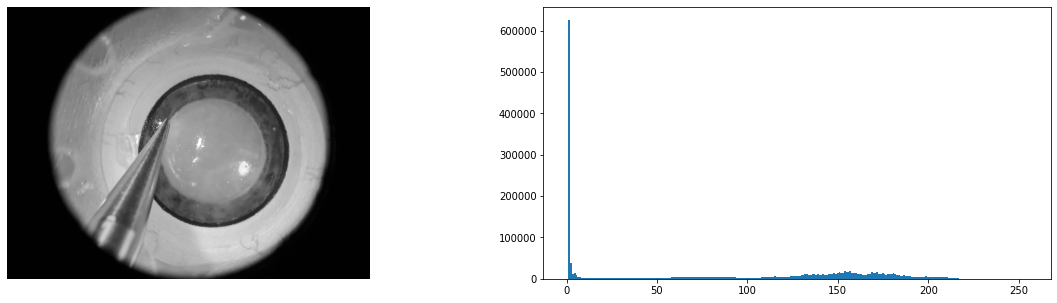

In [2]:
base_gray = cv2.imread('data/artificial/instrument.jpeg', cv2.IMREAD_GRAYSCALE)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,5))
plot1.imshow(base_gray, cmap=plt.cm.gray)
plot1.axis('off')

plot2.hist(base_gray.ravel(), bins=256)

plt.show()

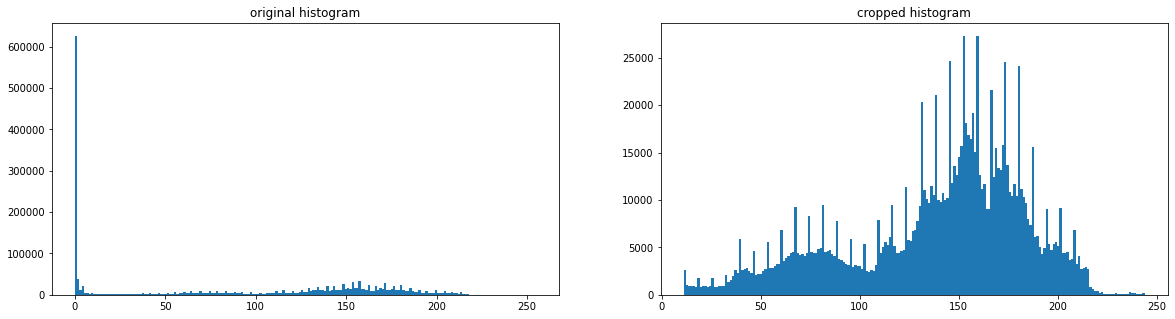

In [3]:
bins = 200

base_gray_values = base_gray.ravel()
cropped_values = base_gray_values[np.where((base_gray_values > 10) & (base_gray_values < 245))]

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,5))
plot1.set_title('original histogram')
plot1.hist(base_gray_values, bins=bins)

plot2.set_title('cropped histogram')
plot2.hist(cropped_values, bins=bins)

plt.show()

In [4]:
base_small = cv2.resize(base_gray, None, fx=0.25, fy=0.25)

print('original shape: %s' % str(base_gray.shape))
print('scaled shape: %s' % str(base_small.shape))

original shape: (1200, 1600)
scaled shape: (300, 400)


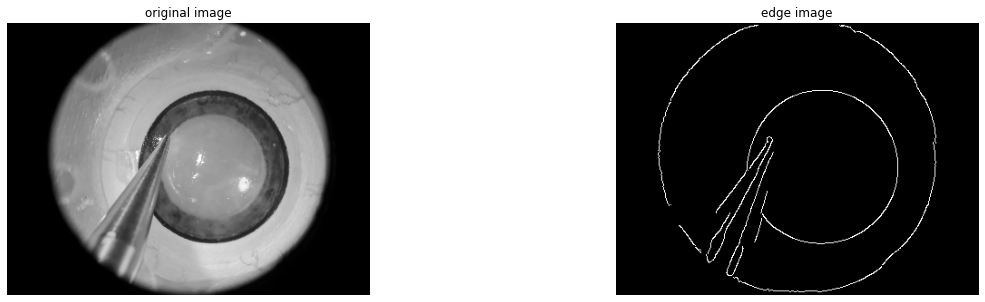

In [5]:
high_tres = 150
low_tres = high_tres//2

base_canny = cv2.Canny(cv2.GaussianBlur(base_small, ksize=(0,0), sigmaX=2), low_tres, high_tres)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,5))
plot1.set_title('original image')
plot1.imshow(base_small, cmap=plt.cm.gray)
plot1.axis('off')

plot2.set_title('edge image')
plot2.imshow(base_canny, cmap=plt.cm.gray)
plot2.axis('off')

plt.show()

In [6]:
base_original = base_small
base_for_hough = cv2.GaussianBlur(255 - base_original, ksize=(0,0), sigmaX=2)

circles = cv2.HoughCircles(
    base_for_hough,
    cv2.HOUGH_GRADIENT, dp=1, minDist=10,
    param1=150, param2=1,
    minRadius=base_for_hough.shape[0]//10, maxRadius=base_for_hough.shape[0]//2
)
best_circle = circles[0,0,:]

circles detected: 773


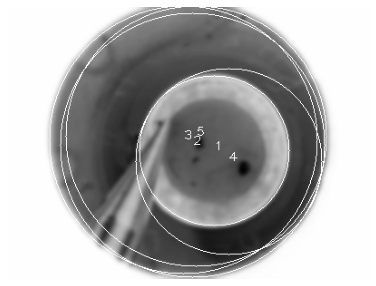

In [7]:
print('circles detected: %s' % circles.shape[1])
circles_filtered = circles[:,:5,:]
# circles_filtered = circles

base_circles = base_for_hough.copy()
circles_filtered = np.uint16(np.around(circles_filtered))
for i, circle in enumerate(circles_filtered[0,:]):
    cv2.circle(base_circles, (circle[0], circle[1]), circle[2], 255, 1)
    cv2.putText(base_circles, str(i + 1), (circle[0], circle[1]), cv2.FONT_HERSHEY_PLAIN, 1, 255, 1)

fig, plot1 = plt.subplots(1, 1, figsize=(20,5))
plot1.imshow(base_circles, cmap=plt.cm.gray)
plot1.axis('off')

plt.show()

In [10]:
limbus_mask = np.zeros(base_for_hough.shape, dtype=base_for_hough.dtype)
cv2.circle(limbus_mask, (best_circle[0], best_circle[1]), round((1.0 + 0.05)*best_circle[2]), 255, cv2.FILLED)
cv2.circle(limbus_mask, (best_circle[0], best_circle[1]), round((1.0 - 0.05)*best_circle[2]), 1, cv2.FILLED)

<ipython-input-10-92a817232edb>:2: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(limbus_mask, (best_circle[0], best_circle[1]), round((1.0 + 0.05)*best_circle[2]), 255, cv2.FILLED)
<ipython-input-10-92a817232edb>:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(limbus_mask, (best_circle[0], best_circle[1]), round((1.0 - 0.05)*best_circle[2]), 1, cv2.FILLED)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Hough transform stability
varying parameter values regarding the transform and analyzing circles with most hits

In [16]:
correct_iris_center = np.array([227.5, 158.5], dtype=np.float32)
correct_iris_radius = np.float32(82.9)

def get_hough_circles(img, sigma, minDist, param1, param2):
    base_for_hough = cv2.GaussianBlur(255 - img, ksize=(0,0), sigmaX=sigma)

    circles = cv2.HoughCircles(
        base_for_hough,
        cv2.HOUGH_GRADIENT, dp=1, minDist=minDist,
        param1=param1, param2=param2,
        minRadius=min(base_for_hough.shape)//10, maxRadius=min(base_for_hough.shape)//2
    )
    
    return circles

base_original = base_small
df = pd.DataFrame(columns=['circle', 'sigma', 'minDist', 'param1', 'param2'])

# grid search
sigmas = range(1, 5 + 1)
minDists = np.linspace(1, min(base_original.shape)/2, num=5)
param1s = np.linspace(1, 200, num=5)
param2s = np.linspace(1, 200, num=5)
for sigma, minDist, param1, param2 in itertools.product(sigmas, minDists, param1s, param2s):
    circles = get_hough_circles(base_original, sigma, minDist, param1, param2)
    
    if circles is not None:
        best_circle = circles[0,0,:]
    else:
        best_circle = None
    
    df = df.append({
        'circle': best_circle,
        'sigma': sigma,
        'minDist': minDist,
        'param1': param1,
        'param2': param2
    }, ignore_index=True)
    
df

,circle,sigma,minDist,param1,param2
0,"[226.5, 156.5, 124.1]",1,1.0,1.0,1.00
1,"[226.5, 156.5, 124.1]",1,1.0,1.0,50.75
2,"[226.5, 156.5, 124.1]",1,1.0,1.0,100.50
3,"[226.5, 156.5, 124.1]",1,1.0,1.0,150.25
4,NaN,1.0,1.0,1.0,200.00
...,...,...,...,...,...
620,NaN,5.0,150.0,200.0,1.00
621,NaN,5.0,150.0,200.0,50.75
622,NaN,5.0,150.0,200.0,100.50
623,NaN,5.0,150.0,200.0,150.25


In [17]:
df_aug = df[~df.circle.isnull()].copy()
df_aug['center_dist'] = df_aug.apply(
    lambda row: np.linalg.norm(row['circle'][:2] - correct_iris_center),
    axis=1
)
df_aug['radius_diff'] = df_aug.apply(
    lambda row: np.abs(row['circle'][2] - correct_iris_radius),
    axis=1
)

df_aug.corr()

,minDist,param1,param2,center_dist,radius_diff
minDist,1.000000e+00,-6.677611e-17,-2.943193e-17,1.698327e-16,1.344324e-17
param1,-6.677611e-17,1.000000e+00,-3.474149e-01,-1.759821e-01,-3.855446e-01
param2,-2.943193e-17,-3.474149e-01,1.000000e+00,-2.623557e-01,-1.190030e-01
center_dist,1.698327e-16,-1.759821e-01,-2.623557e-01,1.000000e+00,7.763833e-01
radius_diff,1.344324e-17,-3.855446e-01,-1.190030e-01,7.763833e-01,1.000000e+00


## Optimal choice of parameters:
judging from the results above:

### param1 (higher threshold for Otsu method)
120 (60-200)
dependent on lighning conditions
### param2
70 (40-125)
more dependent on the size of the iris
### minDist
independent
good set as high as possible for computational purposes
### sigma
2 (2-4)
dependent on the size of the picture

In [18]:
print(df_aug[['param1', 'center_dist', 'radius_diff']].groupby(['param1']).mean())
print()
print(df_aug[['param2', 'center_dist', 'radius_diff']].groupby(['param2']).mean())
print()
print(df_aug[['minDist', 'center_dist', 'radius_diff']].groupby(['minDist']).mean())
print()
print(df_aug[['sigma', 'center_dist', 'radius_diff']].groupby(['sigma']).mean())
print()

        center_dist  radius_diff
param1                          
1.00       7.847797    30.752630
50.75      4.149769     6.099995
100.50     6.397588    12.638461
150.25     4.010415     7.499998
200.00     1.412023     1.066666

        center_dist  radius_diff
param2                          
1.00       8.800469    20.773911
50.75      4.349666    10.227271
100.50     2.317232     9.171426
150.25     3.138725    22.574999

         center_dist  radius_diff
minDist                          
1.00        5.446025    14.626982
38.25       5.446025    14.626982
75.50       5.446025    14.626982
112.75      5.446025    14.626982
150.00      5.446025    14.626982

       center_dist  radius_diff
sigma                          
1         2.062951    12.019997
2         2.574232    15.314284
3         4.467304     5.999999
4         8.770194    12.490906
5        13.011297    33.933332



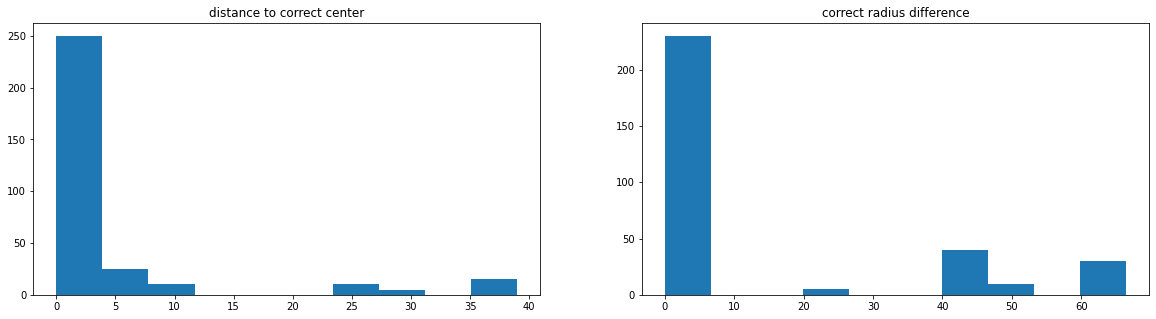

In [19]:
bins = 256

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,5))
plot1.set_title('distance to correct center')
plot1.hist(df_aug['center_dist'].values)

plot2.set_title('correct radius difference')
plot2.hist(df_aug['radius_diff'].values)

plt.show()

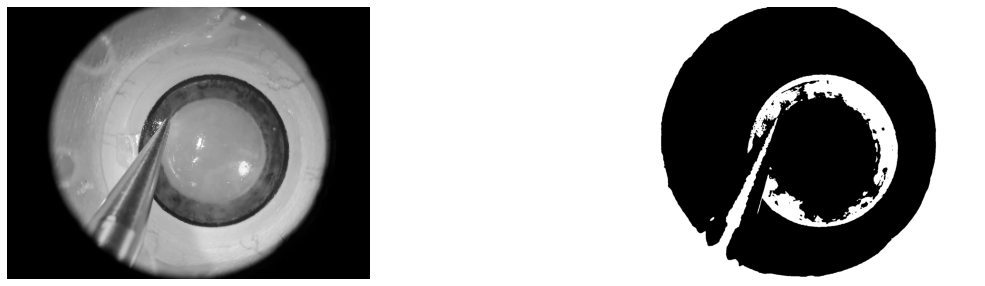

optimal threshold: 84.0


In [20]:
thres_otsu, base_otsu = cv2.threshold(
    src=cv2.GaussianBlur(base_gray, ksize=(0,0), sigmaX=1),
    thresh=0,
    maxval=255,
    type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,5))
plot1.imshow(base_small, cmap=plt.cm.gray)
plot1.axis('off')

plot2.imshow(base_otsu, cmap=plt.cm.gray, vmin=0, vmax=255) 
plot2.axis('off')

plt.show()

print('optimal threshold: %s' % thres_otsu)

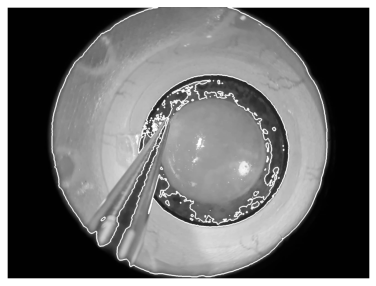

In [21]:
contours, hierarchy = cv2.findContours(base_otsu, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
base_contours = base_gray.copy()
cv2.drawContours(base_contours, contours, -1, 255, 3)

fig, plot1 = plt.subplots(1, 1, figsize=(20,5))
plot1.imshow(base_contours, cmap=plt.cm.gray)
plot1.axis('off')

plt.show()

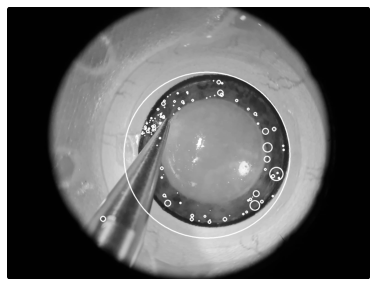

(1200, 1600)


In [22]:
base_contour_circles = base_gray.copy()
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
#     print(radius)
    cv2.circle(
        base_contour_circles, 
        (round(x), round(y)),
        round(radius),
        255, 3
    )
    
fig, plot1 = plt.subplots(1, 1, figsize=(20,5))
plot1.imshow(base_contour_circles, cmap=plt.cm.gray)
plot1.axis('off')

plt.show()

print(base_gray.shape)